In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.0 Importing dependencies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline
import pickle
from scipy.optimize import curve_fit

from datetime import datetime, timedelta
import math
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import os
import random

tf.get_logger().setLevel('ERROR')
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [3]:
tomato = pd.read_csv(r'/content/drive/MyDrive/Data Science Projects/Algeria Greenhouse Project/tomato.csv', encoding="utf-16", delimiter = "\t")
tomato.head()

,时间,日期,室内温度（℃）,室内湿度（%）,室内光照（umol/m2/s）,室内CO2（ppm）,土壤温度（℃）,土壤湿度（%）
0,12:55:15,05/14/2017,33.0,33,2500,445,26.3,18
1,12:56:15,05/14/2017,33.1,35,2500,448,26.3,18
2,12:57:15,05/14/2017,33.0,33,2500,443,26.3,18
3,12:58:15,05/14/2017,33.0,33,2500,443,26.3,18
4,12:59:15,05/14/2017,32.8,33,2500,448,26.3,18


# 2.0 Preprocessing

In [4]:
tomato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319130 entries, 0 to 319129
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   时间               319130 non-null  object 
 1   日期               319130 non-null  object 
 2   室内温度（℃）          319130 non-null  float64
 3   室内湿度（%）          319130 non-null  int64  
 4   室内光照（umol/m2/s）  319130 non-null  int64  
 5   室内CO2（ppm）       319130 non-null  int64  
 6   土壤温度（℃）          319130 non-null  float64
 7   土壤湿度（%）          319130 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 19.5+ MB


In [5]:
tomato.isna().sum()

时间                 0
日期                 0
室内温度（℃）            0
室内湿度（%）            0
室内光照（umol/m2/s）    0
室内CO2（ppm）         0
土壤温度（℃）            0
土壤湿度（%）            0
dtype: int64

## Renaming Columns and combining date & time in one column

In [6]:
tomato.columns = ['time', 'date', 'indoor_temp', 'indoor_humidity', 'indoor_lighting', 'indoor_CO2', 'soil_temp', 'soil_moisture']
tomato['datetime'] = pd.to_datetime(tomato['date'] + " " + tomato['time'])
tomato['datetime'] = pd.to_datetime(tomato['datetime'], format='%d.%m.%Y %H:%M:%S')
tomato = tomato.drop(['date', 'time'], axis = 1)

In [7]:
tomato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319130 entries, 0 to 319129
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   indoor_temp      319130 non-null  float64       
 1   indoor_humidity  319130 non-null  int64         
 2   indoor_lighting  319130 non-null  int64         
 3   indoor_CO2       319130 non-null  int64         
 4   soil_temp        319130 non-null  float64       
 5   soil_moisture    319130 non-null  int64         
 6   datetime         319130 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 17.0 MB


## Outlier Detection

In [8]:
tomato = tomato.set_index('datetime')

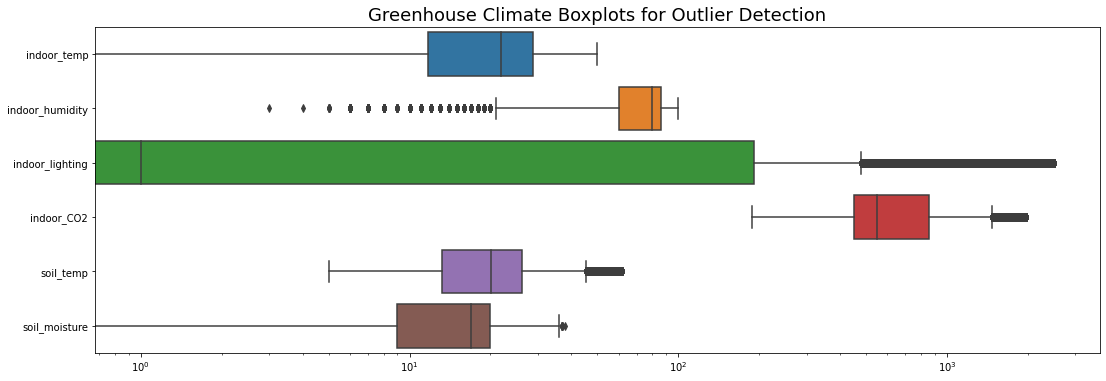

In [9]:
# Plotting Boxplots of the numerical featutomato

plt.figure(figsize = (18,6))
ax =sns.boxplot(data = tomato, orient="h")
ax.set_title('Greenhouse Climate Boxplots for Outlier Detection', fontsize = 18)
ax.set(xscale="log")
plt.show()

In [10]:
#removing outliers from remaining columns and replacing with median i.e. 50th percentile
X_columns = tomato.columns

for col in X_columns:  
  q1, q2, q3 = np.percentile(tomato[col], 25), np.percentile(tomato[col], 50), np.percentile(tomato[col], 75)
  IQR = q3 - q1
  upper_limit = q3 + (1.5 * IQR)
  lower_limit = q1 - (1.5 * IQR)
  tomato.loc[tomato[col]< lower_limit, col] = q2
  tomato.loc[tomato[col]> upper_limit, col] = q2  

# 3.0 EDA

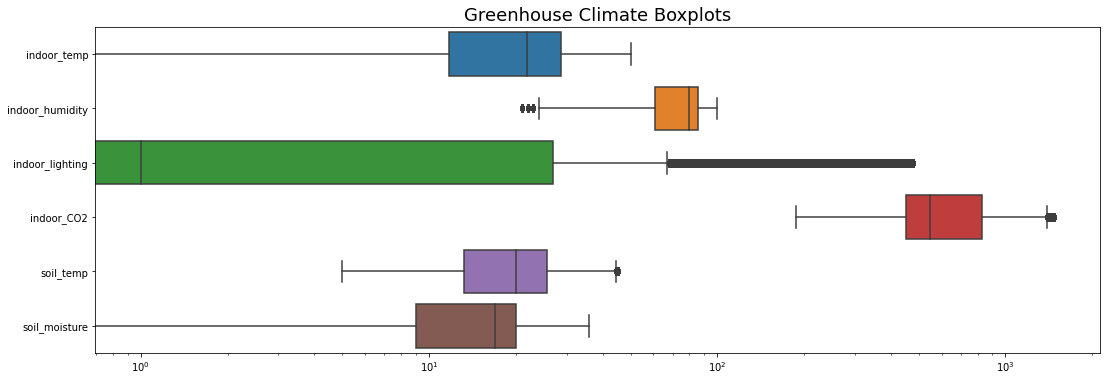

In [11]:
# Boxplot 

plt.figure(figsize = (18,6))
ax =sns.boxplot(data = tomato, orient="h")
ax.set_title('Greenhouse Climate Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

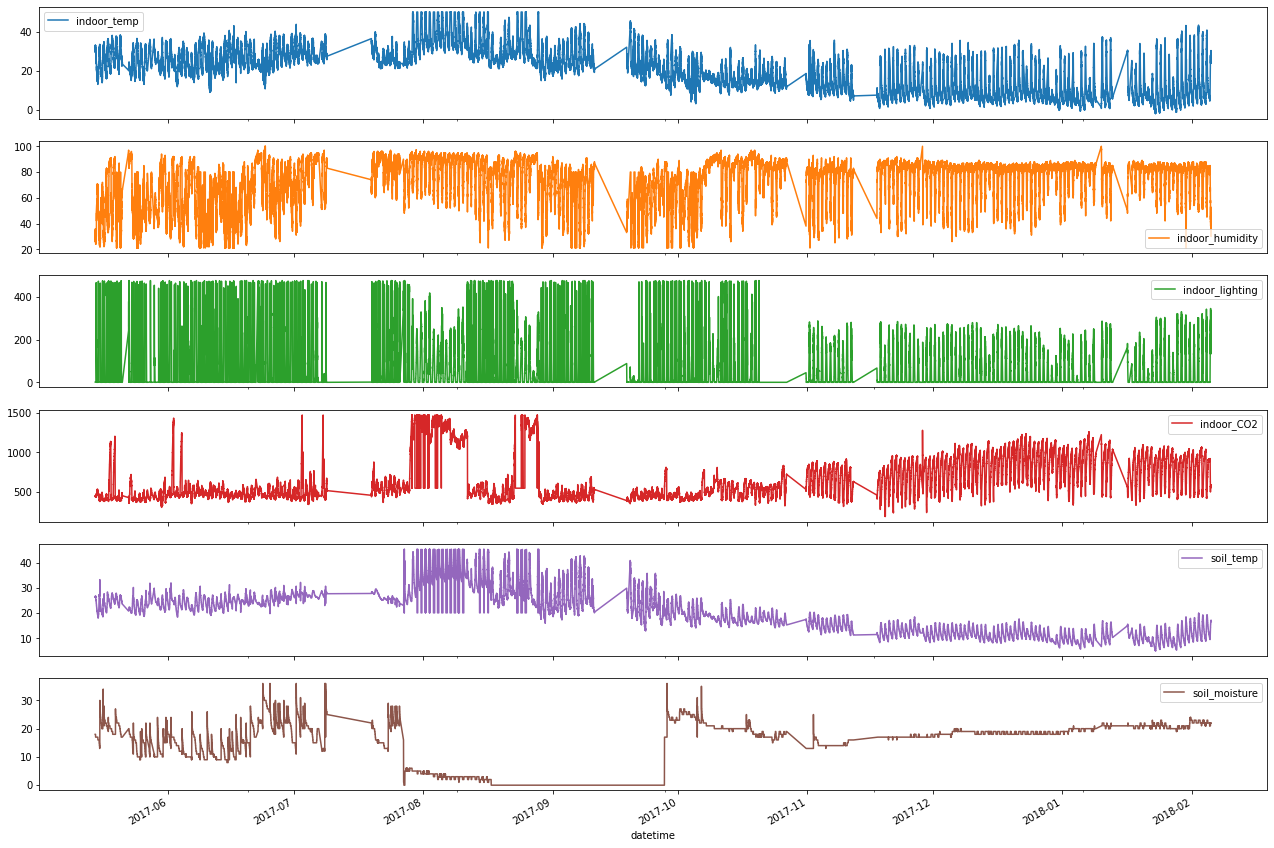

In [12]:
tomato.plot(figsize = (22, 16), subplots=True, layout=(6,1),);

## 3.1 Handling missing dates

In [13]:
tomato = tomato.reset_index()

In [14]:
tomato['delta'] = tomato['datetime'].diff()
tomato['delta'] = tomato['delta'] / np.timedelta64(1, 'm')

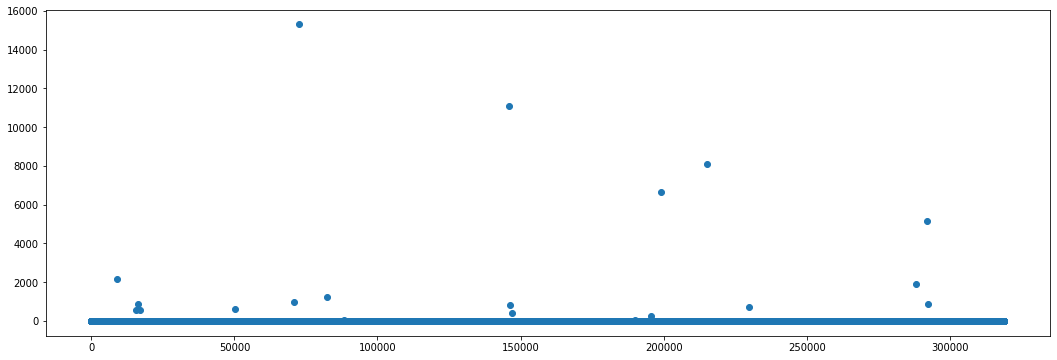

In [15]:
plt.figure(figsize = (18,6))
plt.scatter(x = np.arange(tomato.shape[0]), y = tomato['delta']);


In [16]:
# strategy here is to get index values of all timstamp having delta more than 15mins
# then for each timestamp, using timedelta we wil create a list with 1 min interval 
# between index with delta more than 15mins and the one before it
# then merge all these missing timestamps with original timestamps
# create df with these new timestamps

missing_date_index = tomato[tomato['delta']>15].index.to_list()

missing_timestamplist = []

for i in range(len(missing_date_index)):
  limit = math.ceil(tomato['delta'][missing_date_index[i]])
  list1 = [tomato['datetime'][missing_date_index[i]-1] + timedelta(minutes=j) for j in range(limit)]
  missing_timestamplist.append(list1)

missing_timestamplist_merged = [item for sublist in missing_timestamplist for item in sublist]
og_timestamp_list = tomato['datetime'].to_list()

final_timestamp_list = og_timestamp_list + missing_timestamplist_merged
final_timestamp_list.sort()

In [17]:
tomato_all_dates = pd.DataFrame()
tomato_all_dates['datetime'] = final_timestamp_list
print(tomato_all_dates.shape)
tomato_all_dates.head()

(377502, 1)


,datetime
0,2017-05-14 12:55:15
1,2017-05-14 12:56:15
2,2017-05-14 12:57:15
3,2017-05-14 12:58:15
4,2017-05-14 12:59:15


In [18]:
tomato_merged = pd.merge(tomato, tomato_all_dates, how = 'right', on = 'datetime')
tomato_merged = tomato_merged.drop('delta', axis = 1)
print(tomato_merged.shape)
tomato_merged.head()

(380434, 7)


,datetime,indoor_temp,indoor_humidity,indoor_lighting,indoor_CO2,soil_temp,soil_moisture
0,2017-05-14 12:55:15,33.0,33.0,1.0,445.0,26.3,18.0
1,2017-05-14 12:56:15,33.1,35.0,1.0,448.0,26.3,18.0
2,2017-05-14 12:57:15,33.0,33.0,1.0,443.0,26.3,18.0
3,2017-05-14 12:58:15,33.0,33.0,1.0,443.0,26.3,18.0
4,2017-05-14 12:59:15,32.8,33.0,1.0,448.0,26.3,18.0


In [19]:
tomato_merged = tomato_merged.set_index('datetime')
tomato_merged.isna().sum()

indoor_temp        58352
indoor_humidity    58352
indoor_lighting    58352
indoor_CO2         58352
soil_temp          58352
soil_moisture      58352
dtype: int64

## 3.2 Curve Fitting

In [20]:
tomato_merged = tomato_merged.reset_index()

In [21]:
#Curve fitting does not work on Datetime data. Hence, calculating the time diff between min_date and the datetime 
#at each row in hours to get around to that
min_date = tomato['datetime'][0]
tomato['hrdiff'] = (tomato['datetime'] - pd.Timestamp(min_date)).astype('timedelta64[h]')
tomato_merged['hrdiff'] = (tomato_merged['datetime'] - pd.Timestamp(min_date)).astype('timedelta64[h]')

In [22]:
def objective1(x, a, b, c, d, e):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + e

col_list = tomato.set_index('datetime').columns.to_list()[:6]

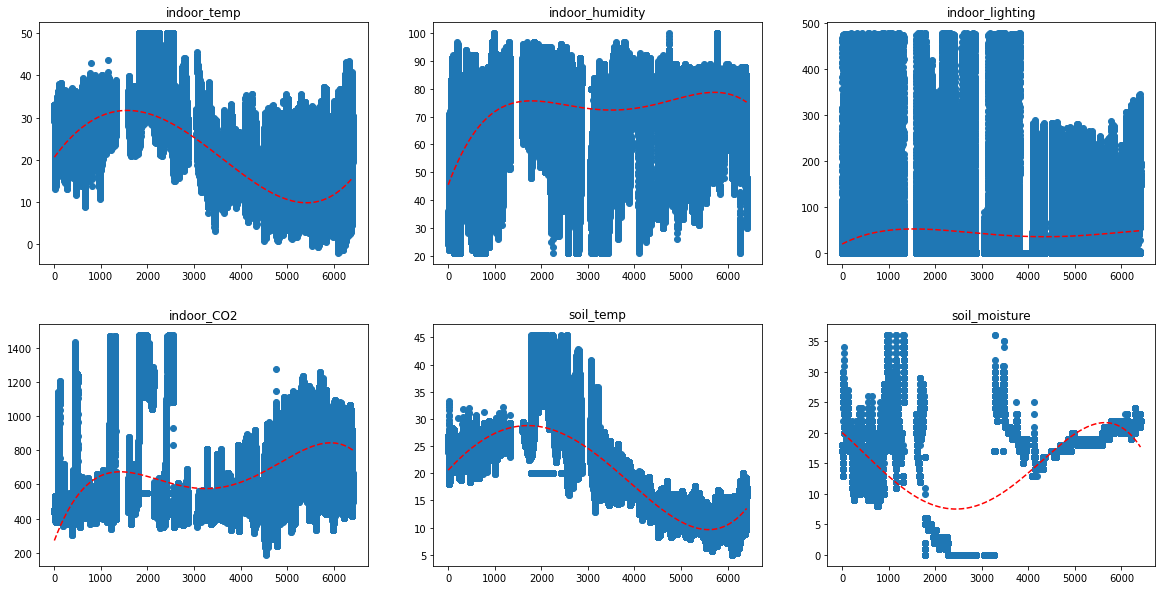

In [23]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.25)

for n, col in enumerate(col_list):

  # add a new subplot iteratively
  ax = plt.subplot(2, 3, n + 1)

  x, y = tomato["hrdiff"], tomato[col]
  popt, _ = curve_fit(objective1, x, y)
  # summarize the parameter values
  a, b, c, d, e  = popt

  # plot input vs output
  ax.scatter(x, y)
  
  # define a sequence of inputs between the smallest and largest known inputs
  x_line = np.arange(min(x), max(x), 1)
  # calculate the output for the range
  y_line = objective1(x_line, a, b, c, d, e)
  # create a line plot for the mapping function
  ax.plot(x_line, y_line, '--', color='red')

  # chart formatting
  ax.set_title(col)  
plt.show()


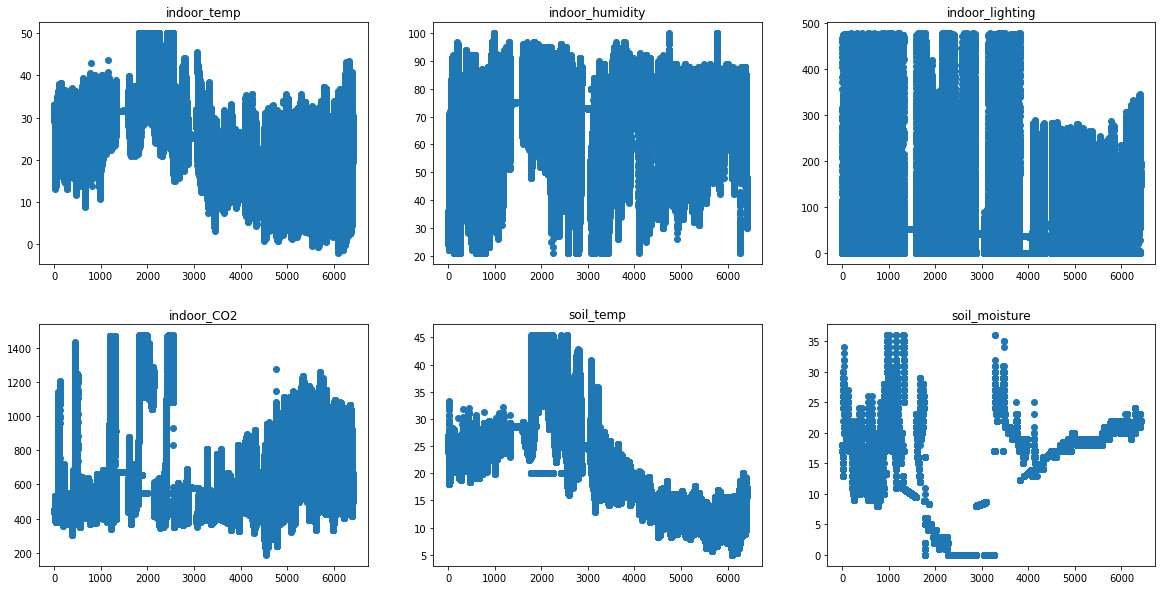

In [24]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.25)

for n, col in enumerate(col_list):

  # add a new subplot iteratively
  ax = plt.subplot(2, 3, n + 1)

  x, y = tomato["hrdiff"], tomato[col]
  popt, _ = curve_fit(objective1, x, y)
  # summarize the parameter values
  a, b, c, d, e  = popt

  for i in range(tomato_merged.shape[0]):
    if pd.isna(tomato_merged[col][i]) == True:
      tomato_merged[col][i] = objective1(tomato_merged['hrdiff'][i], a, b, c, d, e)

  ax.scatter(tomato_merged['hrdiff'], tomato_merged[col]);
  ax.set_title(col)

plt.show()


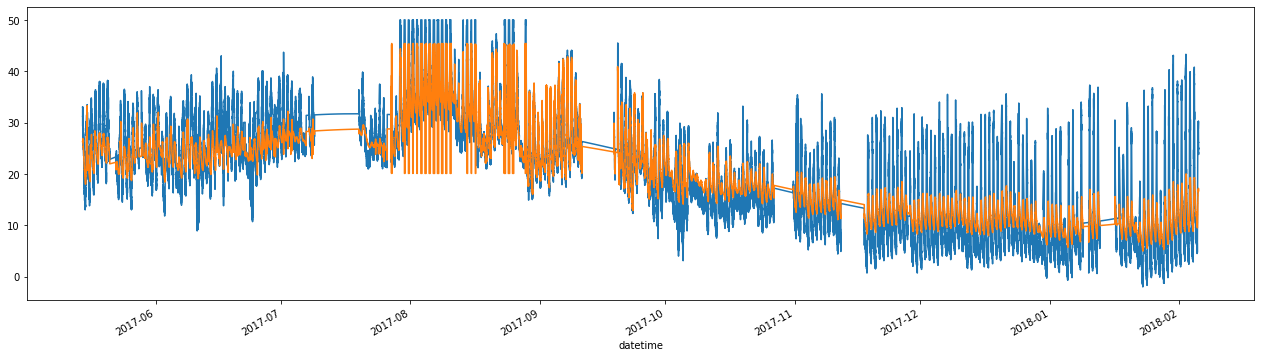

In [25]:
plt.figure(figsize = (22,6))
tomato_merged.set_index('datetime')['indoor_temp'].plot()
tomato_merged.set_index('datetime')['soil_temp'].plot()

plt.show()


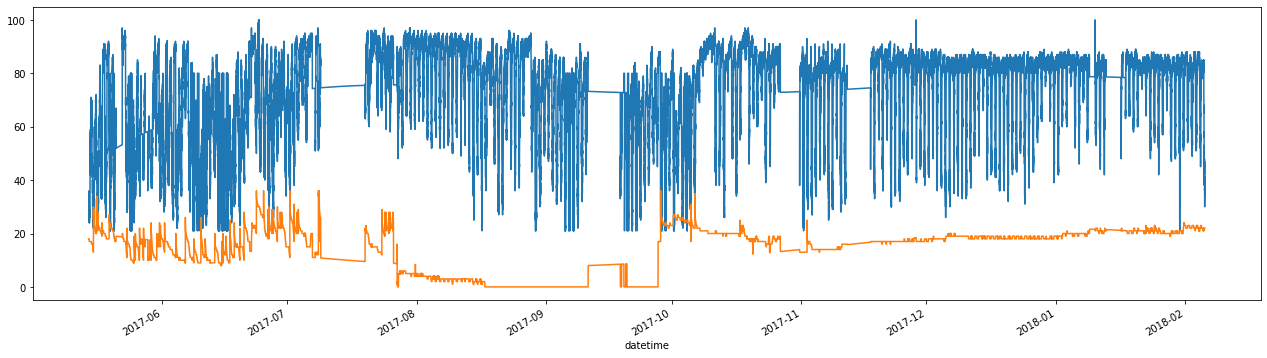

In [26]:
plt.figure(figsize = (22,6))
tomato_merged.set_index('datetime')['indoor_humidity'].plot()
tomato_merged.set_index('datetime')['soil_moisture'].plot()

plt.show()


In [27]:
tomato_merged['hour'] = tomato_merged['datetime'].dt.hour

In [28]:
tomato_merged['period'] = (tomato_merged['datetime'].dt.hour % 24 + 4) // 4
tomato_merged['period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)


# time = [0,4,8,12,16,20,24]
# period = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']

In [29]:
tomato_merged['day_night'] = ""
for i in range(tomato_merged.shape[0]):
  if tomato_merged['datetime'][i].hour in range(8,19):
    tomato_merged['day_night'][i] = 'day'
  else:
    tomato_merged['day_night'][i] = 'night'


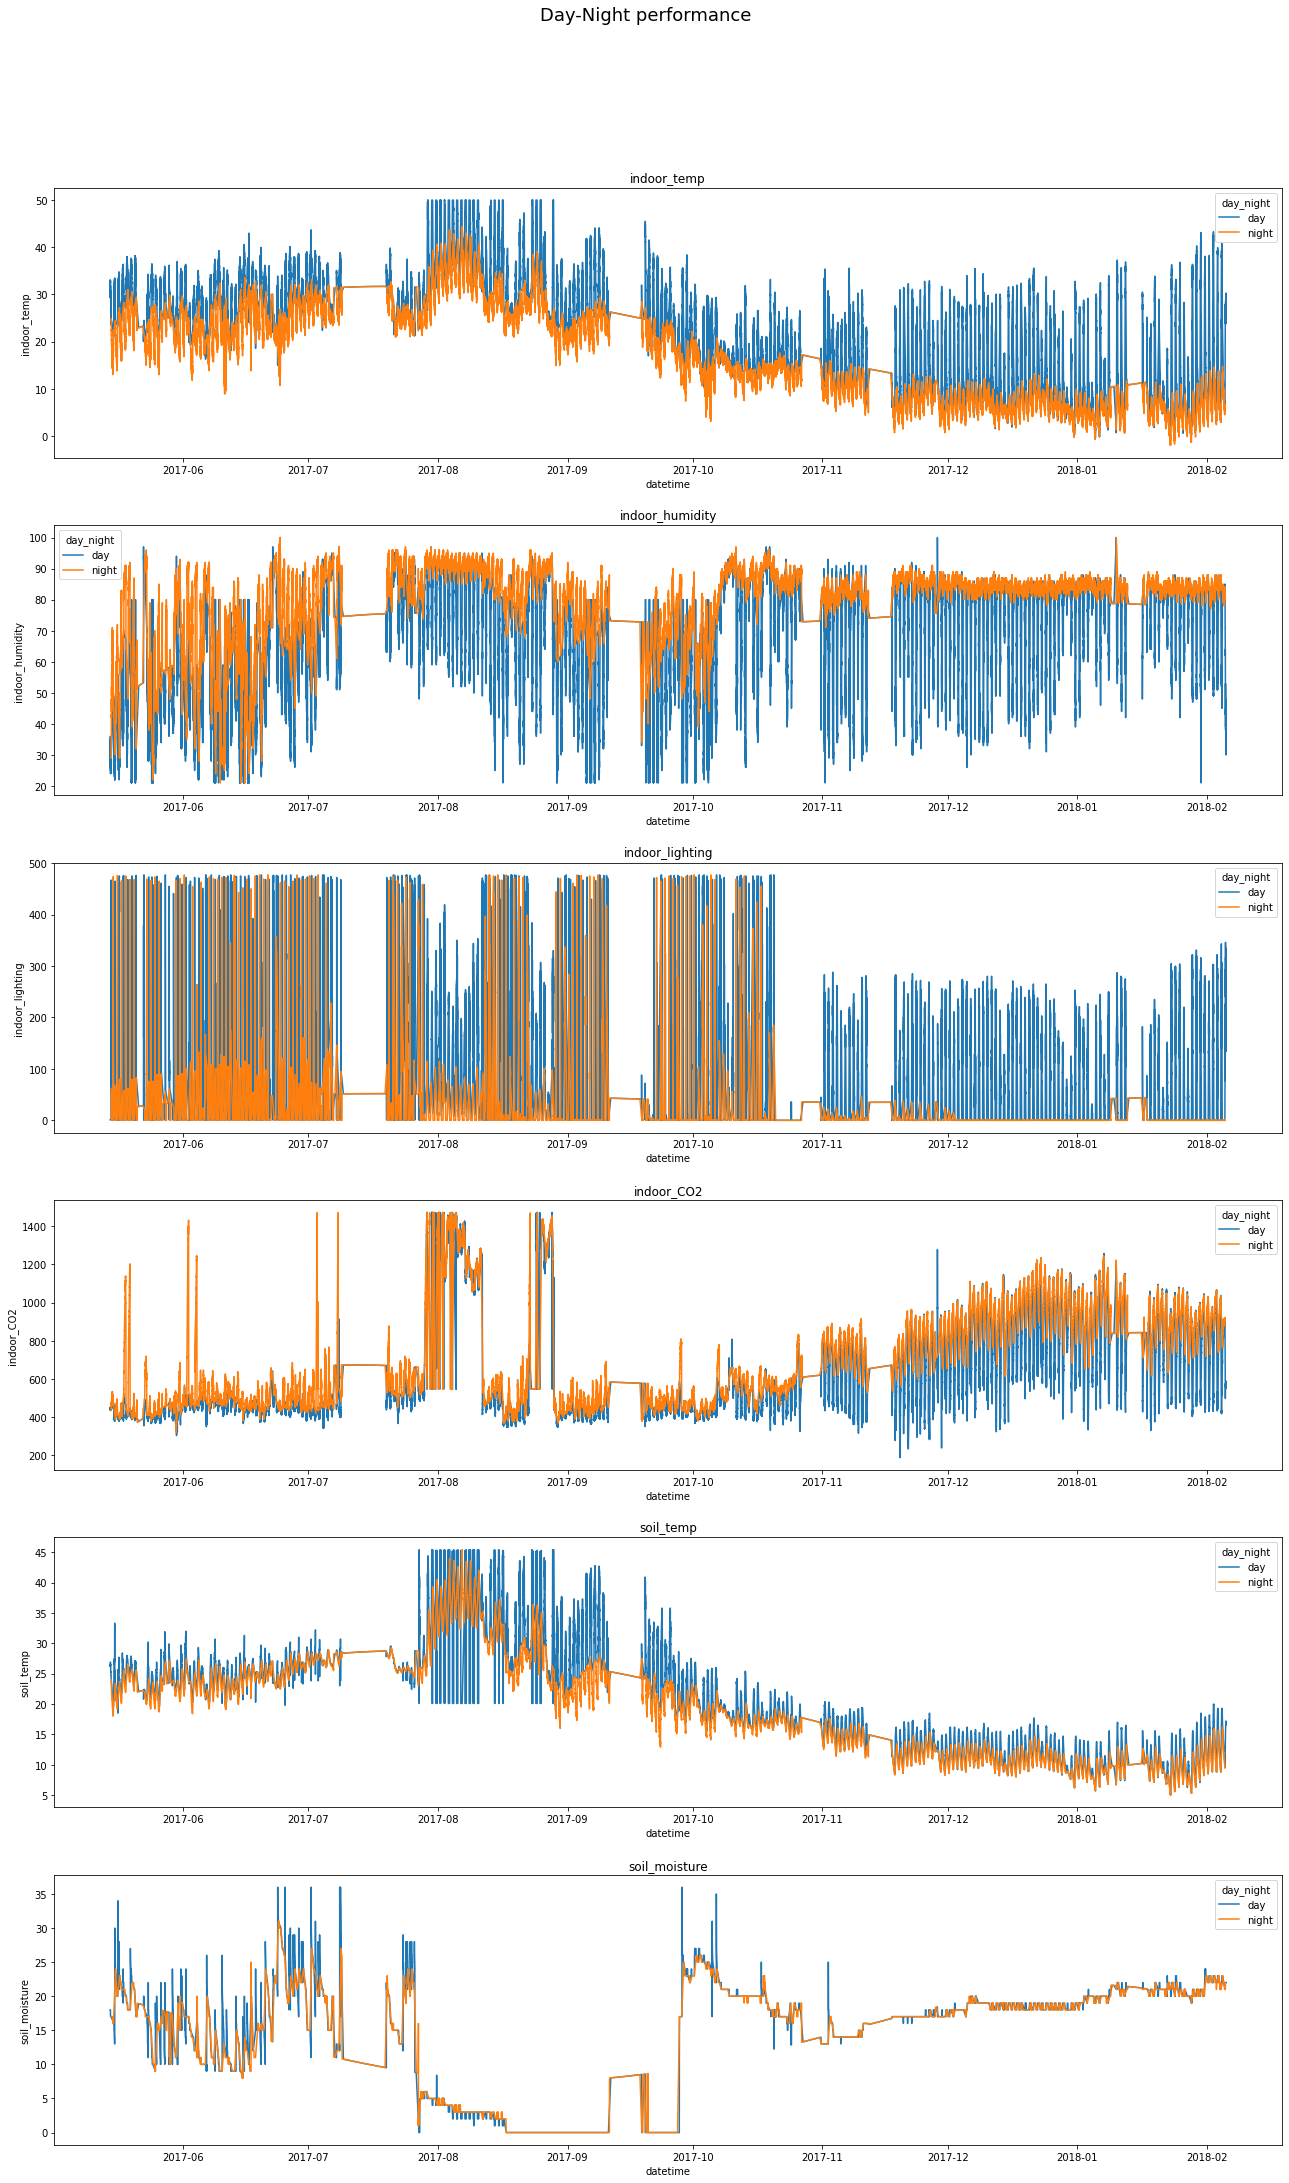

In [30]:
plt.figure(figsize=(22, 36))
plt.subplots_adjust(hspace=0.25)
plt.suptitle("Day-Night performance ", fontsize=18, y=0.95)
col_list = tomato_merged.set_index('datetime').columns.to_list()[:6]

# loop through the length of tickers and keep track of index
for n, col in enumerate(col_list):
    # add a new subplot iteratively
    ax = plt.subplot(6, 1, n + 1)

    # filter df and plot ticker on the new subplot axis
    ax = sns.lineplot(data=tomato_merged, x="datetime", y=col, hue="day_night");

    # chart formatting
    ax.set_title(col)
    #ax.get_legend().remove()
    #ax.set_xlabel("")

plt.show()

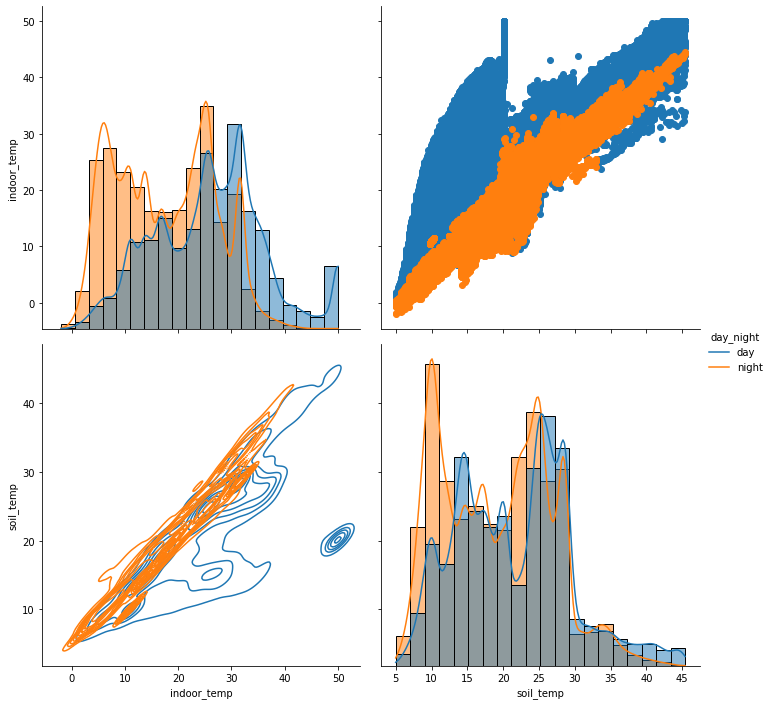

In [31]:
# define data
x, y = tomato_merged["indoor_temp"], tomato_merged["soil_temp"]

df2 = pd.DataFrame(data=tomato_merged, columns=['indoor_temp', 'soil_temp', 'day_night'])

# kdeplot and histplot treat numbers and strings differently when using hue.
# since day_night is a category, convert the column to a string type

g = sns.PairGrid(df2, hue='day_night', height = 5, aspect = 1)

g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot, kde=True, stat='density', bins=20)

_ = g.add_legend()

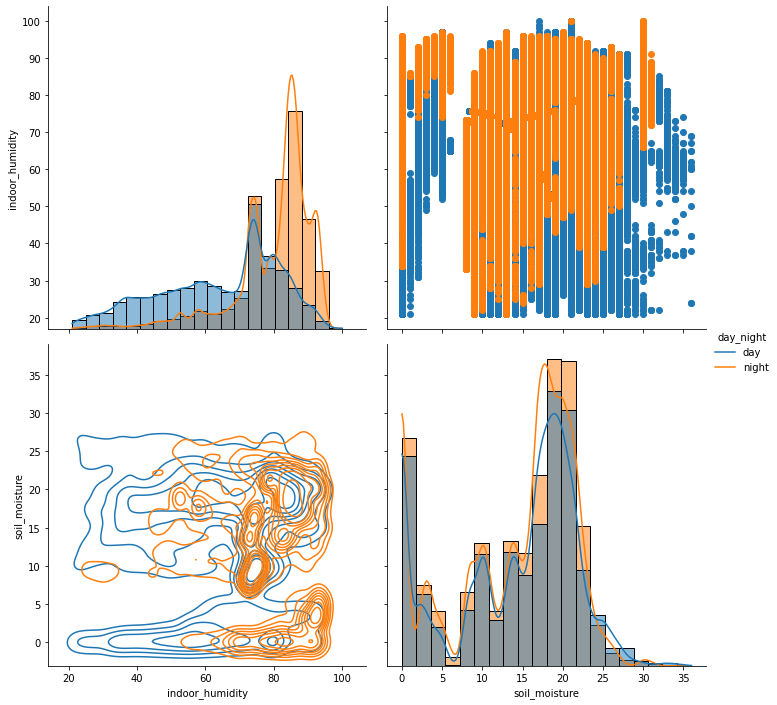

In [32]:
# define data
x, y = tomato_merged["indoor_humidity"], tomato_merged["soil_moisture"]

df2 = pd.DataFrame(data=tomato_merged, columns=['indoor_humidity', 'soil_moisture', 'day_night'])

# kdeplot and histplot treat numbers and strings differently when using hue.
# since day_night is a category, convert the column to a string type

g = sns.PairGrid(df2, hue='day_night', height = 5, aspect = 1)

g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot, kde=True, stat='density', bins=20)

_ = g.add_legend()

In [33]:
tomato_final = tomato_merged.set_index('datetime')[['indoor_temp', 'indoor_humidity', 'indoor_lighting', 'indoor_CO2', 'soil_temp', 'soil_moisture']]

In [34]:
#pickling the combined dataset otherwise we will waste time in doing above curve fitting everytime for new run

import pickle

pickle.dump(tomato_final, open('/content/drive/MyDrive/Data Science Projects/Algeria Greenhouse Project/tomato.pkl', 'wb'))